In [1]:
# importações
import numpy as np
import cv2
import matplotlib.pyplot as plt

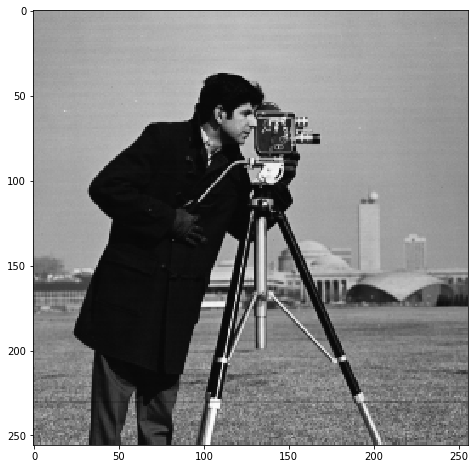

In [34]:
# lendo imagem
cameraman = cv2.imread('cameraman.tiff')
plt.figure(figsize=[8,8])
plt.imshow(cameraman)

In [37]:
def to_grayscale(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

In [61]:
# Função fft utilizando numpy
def fft(img):
    M, N = img.shape
    img_padded = np.pad(img, ((0, M), (0, N)), mode='constant', constant_values=0)
    return np.fft.fftshift(np.fft.fft2(img_padded))

In [62]:
# Magnetude
def magnetude(f_img):
    return np.sqrt(f_img.real**2 + f_img.imag**2)

Text(0.5, 1.0, 'Magnetude da fft')

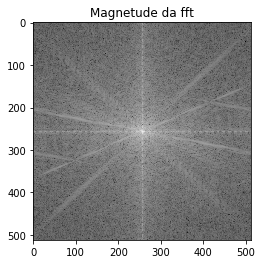

In [63]:
# Visualização do spectrum
f_img = fft(to_grayscale(cameraman))
plt.imshow(30*np.log(magnetude(f_img)), cmap="gray")
plt.title("Magnetude da fft")

In [139]:
# fft inversa
def ifft(f_img):
    deshifted = np.fft.fftshift(f_img)
    img = np.fft.ifft2(deshifted)
    N, M = img.shape
    N, M = N//2, M//2
    return img[:N,:M].real

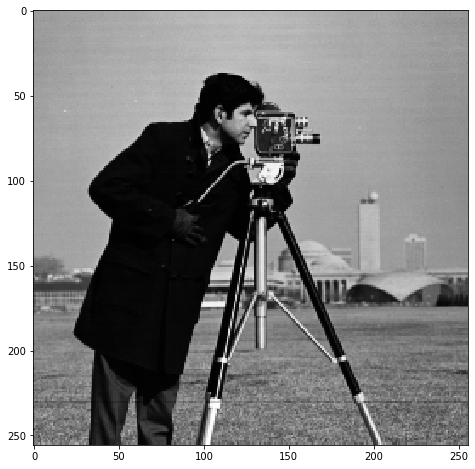

In [140]:
plt.figure(figsize=[8,8])
plt.imshow(ifft(f_img), cmap='gray')

In [160]:
# Calcula matriz das distancias do centro
def matriz_distancia_centro(shape):
    # raio na direção das linhas
    r_row = shape[0]//2
    #raio na direção das colunas
    r_col = shape[1]//2
    m = np.ones(shape) * np.power(np.arange(shape[1]) - r_col, 2)
    n = np.ones((shape[1], shape[0])) * np.power(np.arange(shape[0]) - r_row, 2)
    n = np.swapaxes(n, 0, 1)
    m = n + m
    return np.sqrt(m)

# Calcula filtro passa-baixa de Butterworth
def baixa_butterworth(D, n, shape):
    filtro = np.ones(shape)
    m_distancia = matriz_distancia_centro(shape)
    m_denominador = np.power(m_distancia / D, 2 * n) + 1
    return filtro / m_denominador

# Calcula filtro passa-alta de Butterworth
def alta_butterworth(D, n, shape):
    filtro = np.ones(shape)
    m_distancia = matriz_distancia_centro(shape)
    m_denominador = np.power(D / (m_distancia + 1), 2 * n) + 1
    return filtro / m_denominador

# Aplica filtro no dominio da frequencia
def apply_filter_df(f_img, filtro):
    return f_img * filtro

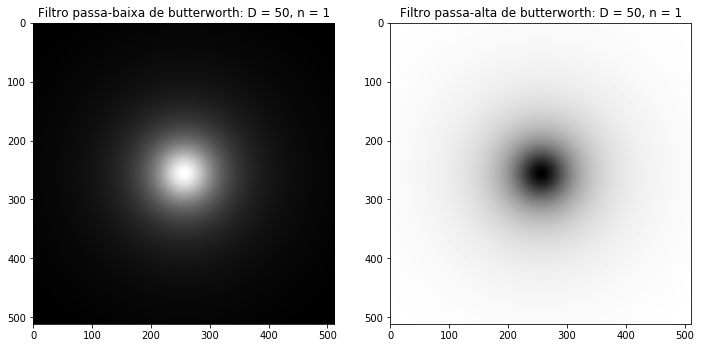

In [161]:
filtro_baixo = baixa_butterworth(50, 1, f_img.real.shape)
filtro_alto = alta_butterworth(50, 1, f_img.real.shape)

plt.figure(figsize=[10, 5.])

plt.subplot(1, 2, 1)
plt.imshow(filtro_baixo, cmap="gray")
plt.title("Filtro passa-baixa de butterworth: D = 50, n = 1")

plt.subplot(1, 2, 2)
plt.imshow(filtro_alto, cmap="gray")
plt.title("Filtro passa-alta de butterworth: D = 50, n = 1")

plt.tight_layout()

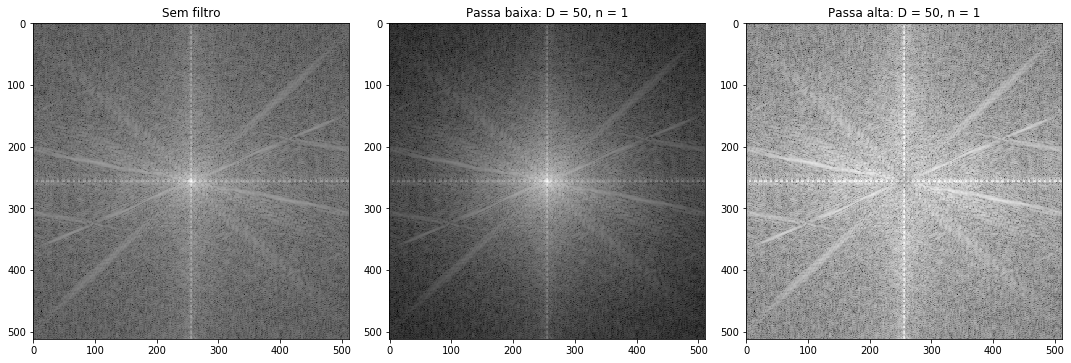

In [162]:
baixa_filtered = apply_filter_df(f_img, filtro_baixo)
alta_filtered = apply_filter_df(f_img, filtro_alto)

plt.figure(figsize=[15, 5.])

plt.subplot(1, 3, 1)
plt.imshow(5*np.log(1 + magnetude(f_img)), cmap="gray")
plt.title("Sem filtro")

plt.subplot(1, 3, 2)
plt.imshow(5*np.log(1 + magnetude(baixa_filtered)), cmap="gray")
plt.title("Passa baixa: D = 50, n = 1")

plt.subplot(1, 3, 3)
plt.imshow(5*np.log(1 + magnetude(alta_filtered)), cmap="gray")
plt.title("Passa alta: D = 50, n = 1")

plt.tight_layout()

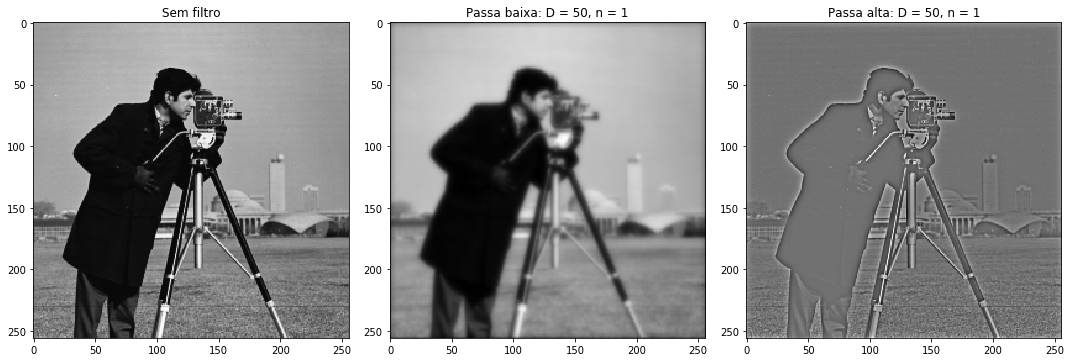

In [154]:
baixa_img = ifft(baixa_filtered)
alta_img = ifft(alta_filtered)
plt.figure(figsize=[15, 5.])

plt.subplot(1, 3, 1)
plt.imshow(cameraman, cmap="gray")
plt.title("Sem filtro")

plt.subplot(1, 3, 2)
plt.imshow(baixa_img, cmap="gray")
plt.title("Passa baixa: D = 50, n = 1")

plt.subplot(1, 3, 3)
plt.imshow(alta_img, cmap="gray")
plt.title("Passa alta: D = 50, n = 1")

plt.tight_layout()

# Explorando as influências dos parâmetros D e n
### Filtro passa-baixa - D variando

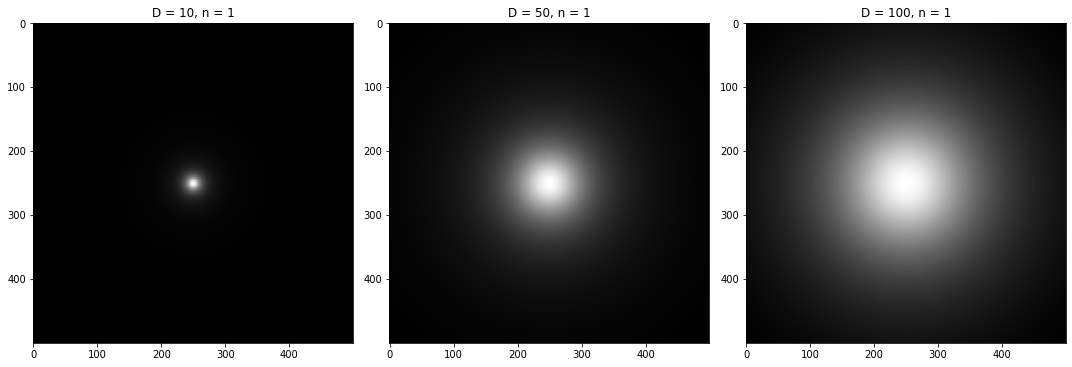

In [170]:
# N fixo, D variando
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.imshow(baixa_butterworth(10,1,(500,500)), cmap="gray")
plt.title("D = 10, n = 1")

plt.subplot(1, 3, 2)
plt.imshow(baixa_butterworth(50,1,(500,500)), cmap="gray")
plt.title("D = 50, n = 1")

plt.subplot(1, 3, 3)
plt.imshow(baixa_butterworth(100,1,(500,500)), cmap="gray")
plt.title("D = 100, n = 1")

plt.tight_layout()

### Filtro passa-baixa - N variando

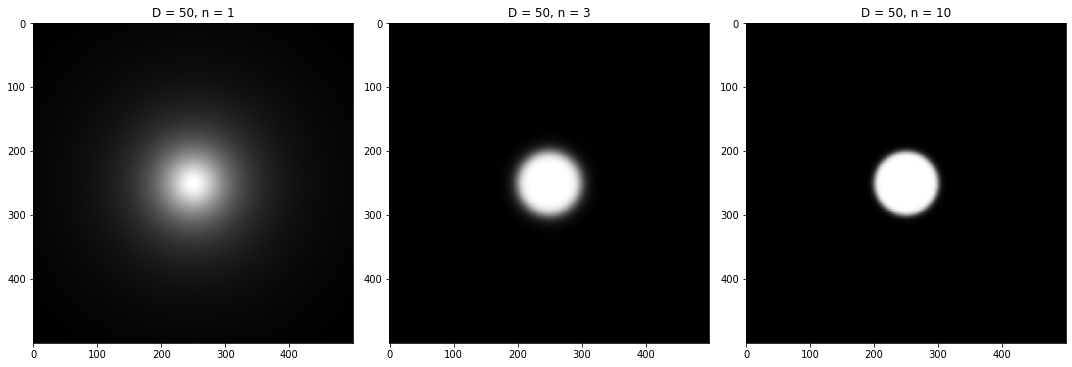

In [173]:
# D fixo, N variando
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.imshow(baixa_butterworth(50,1,(500,500)), cmap="gray")
plt.title("D = 50, n = 1")

plt.subplot(1, 3, 2)
plt.imshow(baixa_butterworth(50,5,(500,500)), cmap="gray")
plt.title("D = 50, n = 3")

plt.subplot(1, 3, 3)
plt.imshow(baixa_butterworth(50,10,(500,500)), cmap="gray")
plt.title("D = 50, n = 10")

plt.tight_layout()

### Filtro passa-baixa - Conclusões
É possivel notar que, quanto maior o valor D, maior será o diametro do circulo no filtro, ou seja, o Diametro do circulo é diretamente proporcional ao parâmetro D. Isto implica que quanto maior o parâmetro D, maiores as frequências que passarão.

Notamos também que o parâmetro N está relacionado a transição dos valores, ou seja, quanto maior o parâmetro N, mais rápida é a transição do branco para o preto nas bordas do circulo. Desta forma, para valores grandes de N, o filtro de Butterworth se aproxima do filtro ideal de passa-baixas. Da mesma forma, para valores pequenos de N, o filtro fica mais próximo do filtro galciano.

### Filtro passa-alta - D variando

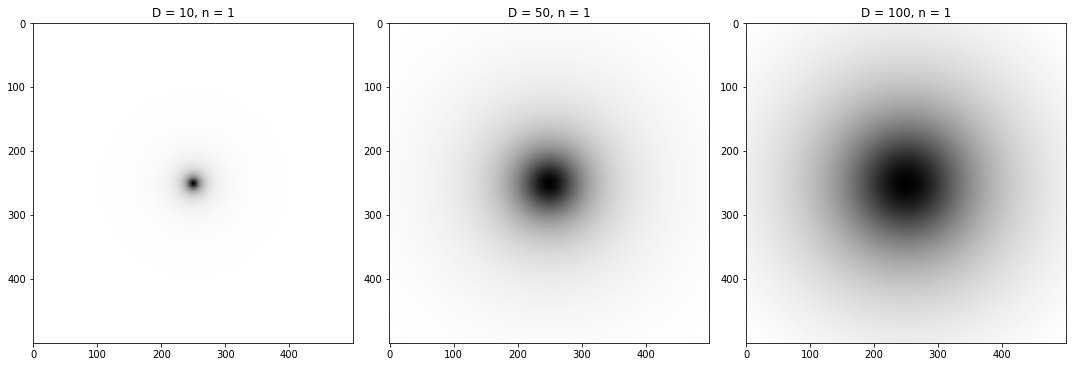

In [174]:
# N fixo, D variando
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.imshow(alta_butterworth(10,1,(500,500)), cmap="gray")
plt.title("D = 10, n = 1")

plt.subplot(1, 3, 2)
plt.imshow(alta_butterworth(50,1,(500,500)), cmap="gray")
plt.title("D = 50, n = 1")

plt.subplot(1, 3, 3)
plt.imshow(alta_butterworth(100,1,(500,500)), cmap="gray")
plt.title("D = 100, n = 1")

plt.tight_layout()

### Filtro passa-alta - N variando

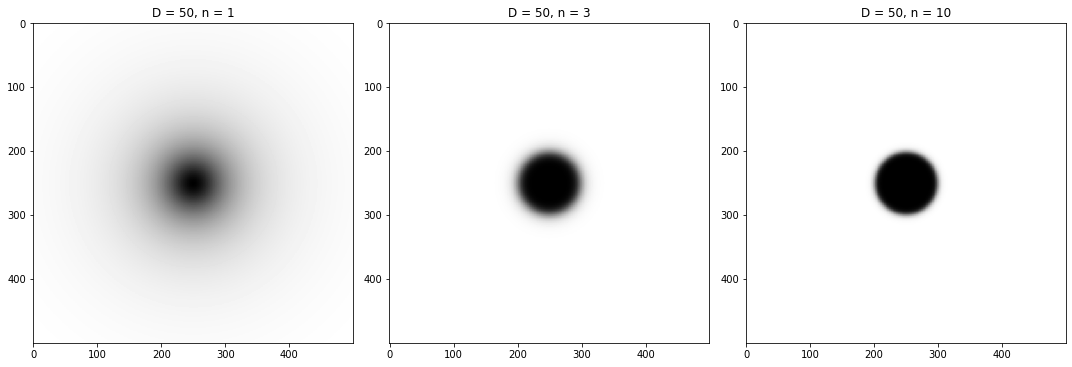

In [175]:
# D fixo, N variando
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.imshow(alta_butterworth(50,1,(500,500)), cmap="gray")
plt.title("D = 50, n = 1")

plt.subplot(1, 3, 2)
plt.imshow(alta_butterworth(50,5,(500,500)), cmap="gray")
plt.title("D = 50, n = 3")

plt.subplot(1, 3, 3)
plt.imshow(alta_butterworth(50,10,(500,500)), cmap="gray")
plt.title("D = 50, n = 10")

plt.tight_layout()

### Filtro passa-alta - Conclusões
Analogamente aos filtros passa-baixa, nos filtros passa-alta o parâmetro D também esta relacionado ao diâmetro do circulo formado, mas desta vez o circulo é de rejeição de frequencia.

Para o parâmetro N não é diferente, ele está relacionado velocidade de transição entre o circulo de rejeição completa e a parte de admissão completa de frequência.

# Critério de escolha do filtro
O critério de escolha dos parâmetros para o filtro vai depender da quantidade de suavisação desejada. Para suavizações maiores, o parâmetro D deve ser menor. Para leves suavizações, o parâmetro D pode ser grande.
Já para o filtro de passa-alta, quanto maior o valor D, maiores serão as frequencias admitidas.

Se o parâmetro N for grande, o filtro será parecido com o filtro ideal, e artefatos poderão ser criados na filtragem, por tanto é necessário que N não seja muito grande para obter uma boa filtragem.